# Check file size

In [2]:
import os
import sys
import bz2
import json

In [6]:
LOAD_PATH = '/sciclone/data10/twford/reddit/reddit/comments/'

year = 2010
month = '01'

file_path = f'{LOAD_PATH}RC_{year}-{month}.bz2'

file_size = os.path.getsize(file_path)
print(f'File size: {file_size / (1024 * 1024):.2f} MB')

total, nonblank, nondeleted = 0, 0, 0
sentences = []
with bz2.open(file_path, 'rb') as f:
    for line in f:
        entry = json.loads(line)
        total += 1
        if 'body' in entry:
            nonblank += 1
            if entry['author'] != '[deleted]':
                nondeleted += 1
                sentences.append(entry['body'])

        if nondeleted % 1000000 == 0:
            memory_size = sys.getsizeof(sentences)
            print(f'Memory size of sentences array ({nondeleted}): {memory_size / (1024 * 1024):.2f} MB')

print(total, nonblank, nondeleted)

File size: 251.51 MB
Memory size of sentences array (1000000): 8.06 MB
Memory size of sentences array (2000000): 16.33 MB
2884096 2884096 2208243


# EDA

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
PATH = '/sciclone/geograd/stmorse/reddit'

```
find /sciclone/data10/twford/reddit/reddit/comments -maxdepth 1 -type f -exec du -k {} + | awk '{print $2, $1}' > filesizes.txt
```

In [19]:
res = []
with open(PATH + '/filesizes.txt', 'r') as f:
    for line in f:
        fname, fsize = line.split(' ')
        fname = fname.split('/')[-1]
        if fname[:2] != 'RC':
            continue

        fdate = fname.split('.')[0][3:]

        res.append([fdate, int(fsize)])

df = pd.DataFrame(res, columns=['Date', 'Size'])
df['Date'] = pd.to_datetime(df['Date']).dt.to_period('M')
df = df.sort_values(by='Date', ascending=True)
df['Size'] = df['Size'] / (1024*1024)

df.head()

,Date,Size
1,2005-12,0.000111
3,2006-01,0.000328
5,2006-02,0.000854
7,2006-03,0.001183
9,2006-04,0.001850


Text(0, 0.5, 'Filesize (Gb)')

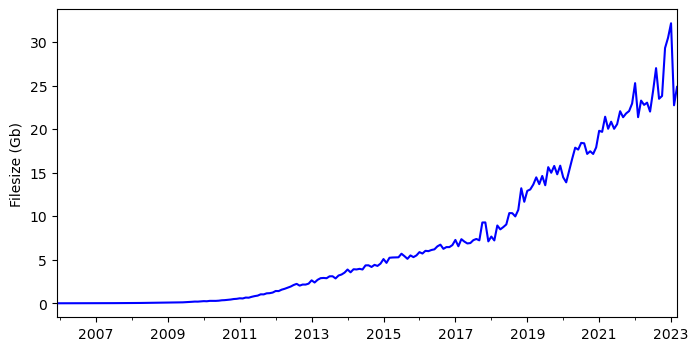

In [24]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

df.plot('Date', 'Size', color='b', linestyle='-', ax=ax, legend=False)
ax.set_xlabel('')
ax.set_ylabel('Filesize (Gb)')

# Testing SentenceTransformer stability

In [1]:
from sentence_transformers import SentenceTransformer

/sciclone/home/stmorse/.conda/envs/torch-tik-env/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
sentences = ["Hello this is a test", "Im testing stability"]

model = SentenceTransformer('all-MiniLM-L6-v2', model_kwargs={'torch_dtype': 'float16'})

encoded1 = model.encode(sentences)

model2 = SentenceTransformer('all-MiniLM-L6-v2', model_kwargs={'torch_dtype': 'float16'})

encoded2 = model2.encode(sentences)

In [3]:
print(encoded1[:,:3])
print(encoded2[:,:3])

[[-0.02673   0.04538  -0.01756 ]
 [-0.006775 -0.02313  -0.06976 ]]
[[-0.02673   0.04538  -0.01756 ]
 [-0.006775 -0.02313  -0.06976 ]]


# Testing clustering algorithms

In [13]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import Birch
from sklearn.datasets import make_blobs

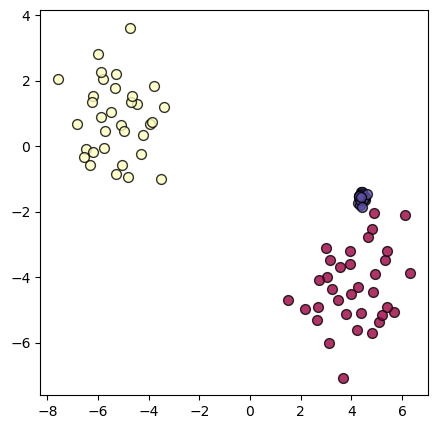

In [9]:
X, labels_true = make_blobs(
    n_samples=100,
    centers=3,
    cluster_std=[1, 1, 0.1],
    random_state=123
)

fig, ax = plt.subplots(1,1, figsize=(5,5))
unique_labels = np.unique(labels_true)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, color in zip(unique_labels, colors):
    ci = np.where(labels_true == k)[0]
    ax.scatter(X[ci, 0], X[ci, 1], c=[color], s=50, edgecolors='k', alpha=0.8, label=k)

plt.show()

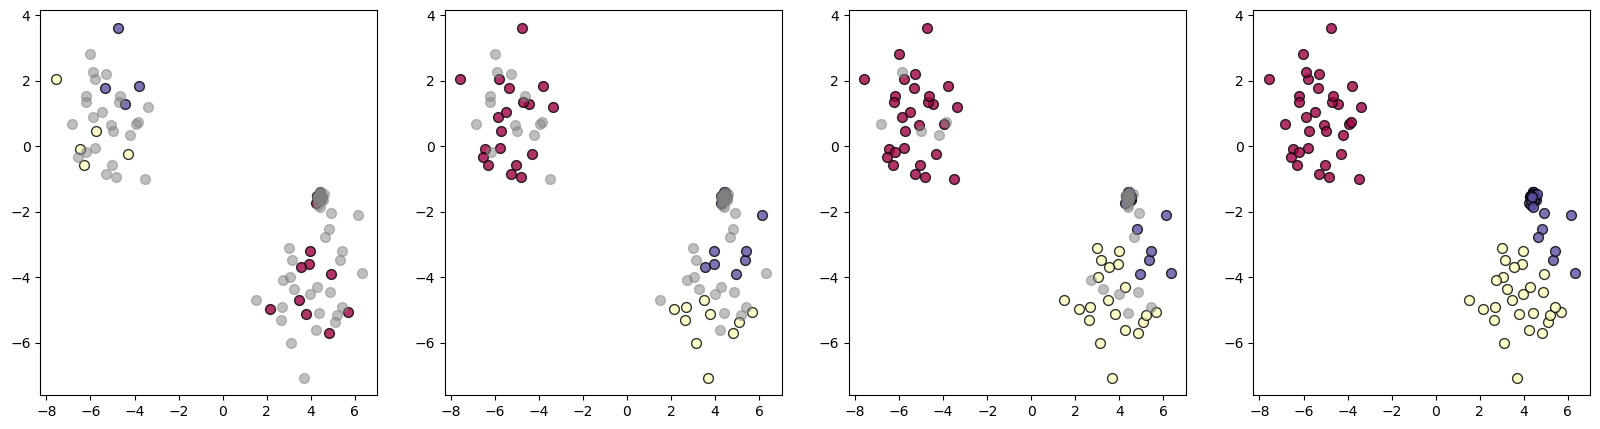

In [17]:
cm = Birch(n_clusters=3, threshold=0.2)

fig, axs = plt.subplots(1,4, figsize=(20,5))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

# partition the data into 5 chunks, do partial_fit, and plot the labels
for i, ax in enumerate(axs):
    start = i*25
    end = (i+1)*25

    cm.partial_fit(X[start:end])
    partial_labs = cm.predict(X[:end])
    partial_unique = np.unique(partial_labs)
    
    for k, color in zip(partial_unique, colors):
        ci = np.where(partial_labs == k)[0]
        ax.scatter(X[:end][ci, 0], X[:end][ci, 1], 
                   c=[color], s=50, edgecolors='k', alpha=0.8, label=k)
    
    ax.scatter(X[end:, 0], X[end:, 1], 
               c='gray', s=50, alpha=0.5)

plt.show()

# Loading / checking data

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import bz2   # bzip2 for .bz2
import lzma  # xz for .xz
# import zstandard as zstd  # zstd for .zst

import json
import os

In [3]:
path = '/sciclone/data10/twford/reddit/reddit/'

In [4]:
# this will store all JSON objects
res = []

# yrs and dates to search
yrs = [2006, 2007]
mos = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

# loop through all years and months
for yr in yrs:
    for mo in mos:
        filename = f'RC_{yr}-{mo}.bz2'
        print(f'{filename}...')
        with bz2.BZ2File(path + 'comments/' + filename, 'rb') as file:
            for line in file:
                if len(line) < 10:
                    continue
                res.append(json.loads(line))


RC_2006-01.bz2...
RC_2006-02.bz2...
RC_2006-03.bz2...
RC_2006-04.bz2...
RC_2006-05.bz2...
RC_2006-06.bz2...
RC_2006-07.bz2...
RC_2006-08.bz2...
RC_2006-09.bz2...
RC_2006-10.bz2...
RC_2006-11.bz2...
RC_2006-12.bz2...
RC_2007-01.bz2...
RC_2007-02.bz2...
RC_2007-03.bz2...
RC_2007-04.bz2...
RC_2007-05.bz2...
RC_2007-06.bz2...
RC_2007-07.bz2...
RC_2007-08.bz2...
RC_2007-09.bz2...
RC_2007-10.bz2...
RC_2007-11.bz2...
RC_2007-12.bz2...


In [5]:
res[10]

{'parent_id': 't3_22554',
 'edited': False,
 'id': 'c2728',
 'author': 'dfranke',
 'author_flair_text': None,
 'distinguished': None,
 'retrieved_on': 1473821517,
 'gilded': 0,
 'subreddit_id': 't5_6',
 'link_id': 't3_22554',
 'stickied': False,
 'body': "I'm looking forward to the reaction from the ID crowd if this succeeds.",
 'controversiality': 0,
 'score': 3,
 'ups': 3,
 'author_flair_css_class': None,
 'created_utc': 1136091198,
 'subreddit': 'reddit.com'}

In [19]:
users = {}
for r in res:
    if r['author'] not in users:
        users[r['author']] = 1
    else:
        users[r['author']] += 1

user_df = pd.DataFrame(users.items(), columns=['user', 'count'])
user_df = user_df.sort_values(by='count', ascending=False).reset_index(drop=True)

# remove the '[deleted]' user
user_df = user_df[user_df['user'] != '[deleted]']

user_df.head()

,user,count
1,cartooncorpse,7736
2,redditcensoredme,7464
3,NoMoreNicksLeft,6746
4,bobcat,5912
5,newton_dave,5404


In [32]:
uoi = 'bobcat'
k = 10
for r in res:
    if r['author'] == uoi:
        print(r['body'])
        k -= 1
    if k == 0:
        break

The White House translation says "large mouth bass".
http://www.whitehouse.gov/news/releases/2006/05/20060507-2.html

Don't let that stop the bashing, guys. Look at what ELSE he said: 
"I like to tell people, you're equally American whether you're a Jew, Muslim, Christian, or Atheist -- you're equally all Americans -- and that if we ever lose that, we begin to look like the Taliban."

Goddamn atheist-lover!
I can hear that playing through my desktop system from the next room, and I'm 46. My notebook doesn't make a peep, though.
In other news, 50% of Americans have below average intelligence.
No one executed in the US has ever been exonerated posthumously. Can you supply some names and prove me wrong?
How about a couple of paragraphs so I don't have to sit through a long video?
Thank you. I was indeed correct then. I see I got lots of downvotes for it.


There is no video of the interview. Care to recant?
http://en.wikipedia.org/wiki/Citigroup_Center
This soldier is featured at length i

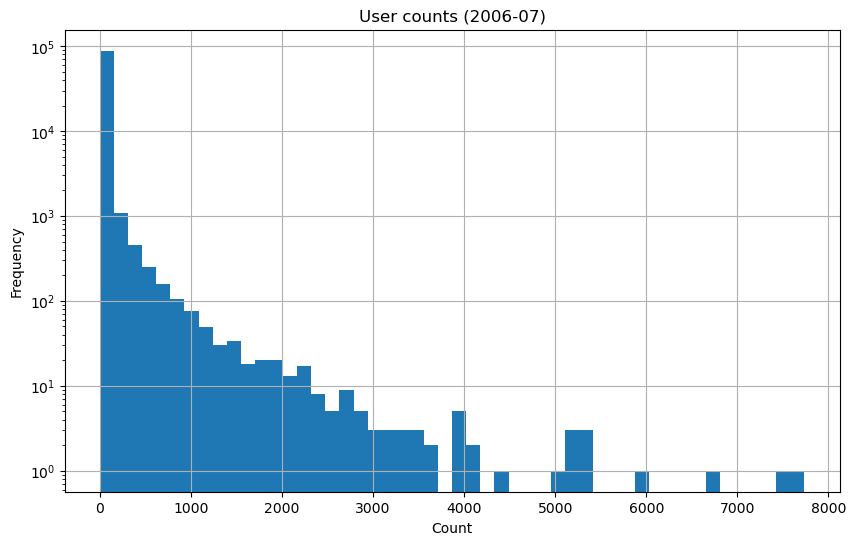

In [33]:
plt.figure(figsize=(10, 6))
user_df['count'].hist(bins=50, log=True)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('User counts (2006-07)')
plt.show()

In [20]:
# grab created_utc and author from raw json
created = []
for r in res:
    created.append((r['author'], r['created_utc']))

# convert to dataframe
created_df = pd.DataFrame(created, columns=['author', 'created_utc'])

# convert created_utc to datetime
created_df['created_utc'] = created_df['created_utc'].astype(int)
created_df['created_dt'] = pd.to_datetime(created_df['created_utc'], unit='s')

created_df.head()


,author,created_utc,created_dt
0,jh99,1136074029,2006-01-01 00:07:09
1,jpb,1136076410,2006-01-01 00:46:50
2,Pichu0102,1136078623,2006-01-01 01:23:43
3,libertas,1136079346,2006-01-01 01:35:46
4,mdmurray,1136081389,2006-01-01 02:09:49


In [23]:
user_df.query('count >= 40 and count <= 50').head()

,user,count
5408,chh,50
5409,Joe091,50
5410,spockbaggins,50
5411,yuubi,50
5412,pqs,50


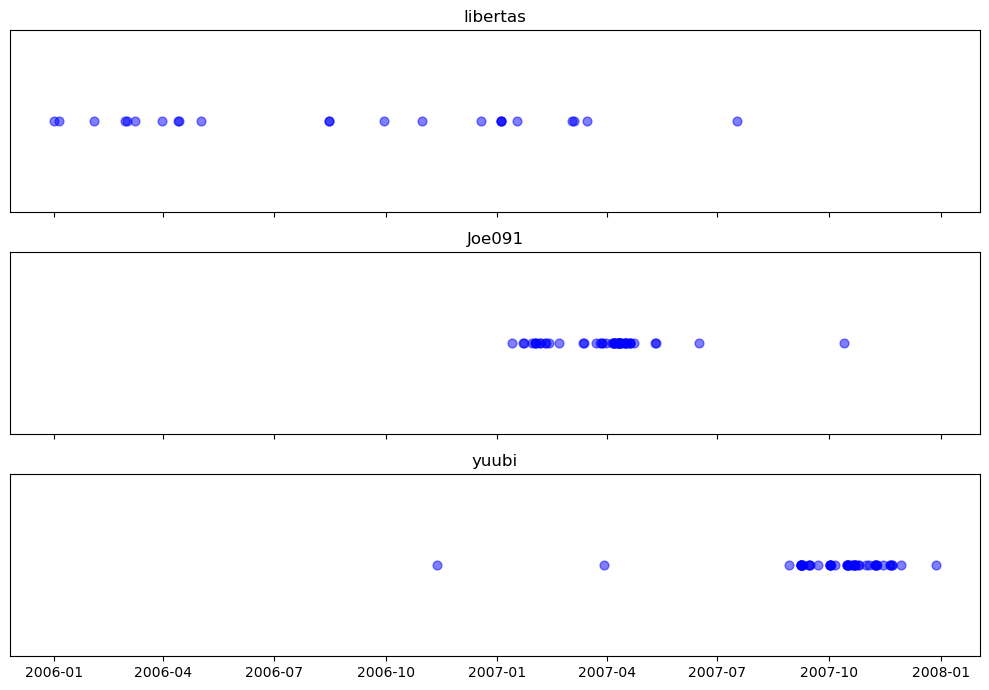

In [26]:
# pull all timestamps for a user and plot on a timeline
users = ['libertas', 'Joe091', 'yuubi']

fig, axs = plt.subplots(3,1, figsize=(10, 7), sharex=True)

for ax, user in zip(axs, users):
    u_df = created_df[created_df['author'] == user]
    u_df = u_df.sort_values(by='created_dt').reset_index(drop=True)

    ax.scatter(u_df['created_dt'], [0]*len(u_df['created_dt']), 
               s=40, c='b', alpha=0.5)
    ax.set_yticks([])
    ax.set_title(f'{user}')

plt.tight_layout()
plt.show()

# ZST files

In [4]:
with zstd.open(os.path.join(path, 'comments/RC_2018-11.zst'), 'rb') as file:
    for line in file:
        print(line)
        break

# with open(os.path.join(path, 'comments/RC_2018-11.zst'), 'rb') as file:
#     dctx = zstd.ZstdDecompressor()
#     with dctx.stream_reader(file) as reader:
#         for line in reader:
#             print(line.decode('utf-8'))
#             break

UnsupportedOperation: 